# Written by jonathan kjellen


In [ ]:
# To run this notebook the package sentence_transformer is needed and can be install by 
# !pip install sentence_transformers

In [5]:
#It is also necessary to have the following 3 files in the correct path or change the path variable to where the data is located:

file_path_opinion_survey = "../../data/data_all/people_opinion_topics.xlsx"
file_path_sentiments = "../../data/data_all/data_question_all_sentiment.csv"
file_path_topics = '../../data/data_all/data_topic_all_notreduedtopics.json'

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import ast
import json
from sentence_transformers import SentenceTransformer, util

In [7]:


df_opinion = pd.read_excel(file_path_opinion_survey,header=1)
df_opinion.rename(columns={'Unnamed: 0': 'Topic'}, inplace=True)
columns_to_change = df_opinion.columns.tolist()[1:32]
for column in columns_to_change:
    df_opinion[column] = df_opinion[column].str.rstrip('%').astype('float') / 100.0

In [8]:

df = pd.read_csv(file_path_sentiments)
df = df.dropna(subset=["question"])
df = df.reset_index()



with open(file_path_topics, 'r') as openfile:
    # Reading from json file
    json_object = json.load(openfile)
df2 = pd.DataFrame(json_object)

df["id_topic_combined"] = df2["id_topic_combined"]
df["mean_diff"] = None

for i in range(len(df)):
    df.at[i,"question_BERT_probs"] = ast.literal_eval(df.iloc[i]["question_BERT_probs"])
    df.at[i,"answer_BERT_probs"] = ast.literal_eval(df.iloc[i]["answer_BERT_probs"])
    differences = [abs(df.iloc[i]["question_BERT_probs"][l] - df.iloc[i]["answer_BERT_probs"][l]) for l in [0,2]]
    sum_diff = sum(differences)
    df.at[i,"mean_diff"] = sum_diff
df = df.dropna(subset=["answer","besvaradav_partibet"])
df = df.reset_index()

In [9]:
model = SentenceTransformer('KBLab/sentence-bert-swedish-cased')
def find_most_correlated(query):
    corpus = df_opinion["Topic"].tolist()
    
    embeddings = model.encode(corpus,convert_to_tensor=True)
    query_embedding = model.encode(query, convert_to_tensor=True)
    #Compute cosine-similarities for each sentence with each other sentence
    #cosine_scores = util.cos_sim(embeddings, query_embedding)
    #top_results = torch.topk(cos_scores, k=top_k)

    hits = util.semantic_search(query_embedding, embeddings, score_function=util.dot_score)
    hits = hits[0]      #Get the hits for the first query

    #print(corpus[hits[0]["corpus_id"]])
    return corpus[hits[0]["corpus_id"]]

In [10]:
def combining_data_from_opinion(date_start,date_end, topic):
    column_index_start = df_opinion.columns.get_loc(date_start)
    column_index_end = df_opinion.columns.get_loc(date_end) + 1

    amount_of_cols = column_index_end - column_index_start

    avg_value = df_opinion[df_opinion["Topic"] == topic].iloc[:, column_index_start:column_index_end].sum().sum()/amount_of_cols
    #print(avg_value) 
    return avg_value

In [11]:
df

,level_0,index,id_,question,question_date,answer,undertecknare_name,undertecknare_partibet,besvaradav_name,besvaradav_partibet,...,answer_len,question_len,question_BERT_label,question_BERT_label_prob,question_BERT_probs,answer_BERT_label,answer_BERT_label_prob,answer_BERT_probs,id_topic_combined,mean_diff
0,0,0,gx11839,\nden \r\n27 maj\nFråga \n2009/10:839 \r\nÖkat...,2010-05-27,\nden 2 juni\nSvar på fråga\n2009/10:839 Ökat ...,Karin Svensson Smith,MP,Åsa Torstensson,C,...,299,262,NEUTRAL,0.843490,"[0.06522286683320999, 0.8434900641441345, 0.09...",NEUTRAL,0.862617,"[0.00812835805118084, 0.8626168966293335, 0.12...",72,0.095062
1,1,1,gx11838,\nden \r\n26 maj\nFråga \n2009/10:838 \r\nFrys...,2010-05-26,\nden \r\n3 juni\nSvar på fråga\n2009/10:838 F...,Birgitta Eriksson,S,Beatrice Ask,M,...,247,160,NEUTRAL,0.881974,"[0.08035985380411148, 0.8819741010665894, 0.03...",NEUTRAL,0.879026,"[0.011046510189771652, 0.8790263533592224, 0.1...",4,0.141574
2,2,2,gx11837,\nden \r\n25 maj\nFråga \n2009/10:837 \r\nSver...,2010-05-25,\nden 4 juni\nSvar på fråga\n2009/10:837 Sveri...,Ameer Sachet,S,Ewa Björling,M,...,480,260,NEUTRAL,0.877386,"[0.035131409764289856, 0.877386212348938, 0.08...",NEUTRAL,0.524766,"[0.017622316256165504, 0.524766206741333, 0.45...",194,0.387638
3,3,3,gx11836,\nden \r\n25 maj\nFråga \n2009/10:836 \r\nSJ o...,2010-05-25,\nden 1 juni\nSvar på fråga\n2009/10:836 SJ oc...,Ameer Sachet,S,Maud Olofsson,C,...,123,200,NEUTRAL,0.501067,"[0.46717265248298645, 0.5010665059089661, 0.03...",NEUTRAL,0.922766,"[0.012958180159330368, 0.922765851020813, 0.06...",0,0.48673
4,4,4,gx11835,\nden \r\n24 maj\nFråga \n2009/10:835 \r\nAvrä...,2010-05-24,\nden 10 juni\nSvar på fråga\n2009/10:835 Avrä...,Helena Bargholtz,FP,Carl Bildt,M,...,218,122,NEUTRAL,0.638073,"[0.03868257254362106, 0.6380729079246521, 0.32...",POSITIVE,0.603525,"[0.008138378150761127, 0.38833656907081604, 0....",17,0.310825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18814,18989,18992,h611701,av Peter Persson (S)\ntill Statsrådet Per Bolu...,2019-05-31,Svar på fråga 2018/19:701 av Peter Persson (S)...,Peter Persson,S,Statsrådet Per Bolund,MP,...,172,235,NEUTRAL,0.867662,"[0.04199288785457611, 0.8676615953445435, 0.09...",NEUTRAL,0.938161,"[0.019609101116657257, 0.9381612539291382, 0.0...",4,0.0705
18815,18990,18993,h611700,av Åsa Coenraads (M)\ntill Infrastrukturminist...,2019-05-29,Svar på fråga 2018/19:700 av Åsa Coenraads (M)...,Åsa Coenraads,M,Infrastrukturminister Tomas Eneroth,S,...,174,73,NEUTRAL,0.925489,"[0.02132927067577839, 0.9254891872406006, 0.05...",NEUTRAL,0.835198,"[0.007261862047016621, 0.8351978063583374, 0.1...",12,0.118426
18816,18991,18994,h61170,av Amineh Kakabaveh (V)\ntill Utrikesminister ...,2019-01-31,Svar på fråga 2018/19:70 av Amineh Kakabaveh (...,Amineh Kakabaveh,V,Utrikesminister Margot Wallström,S,...,188,335,NEUTRAL,0.539820,"[0.017562413588166237, 0.5398198366165161, 0.4...",NEUTRAL,0.568572,"[0.00962839461863041, 0.5685723423957825, 0.42...",17,0.028753
18817,18992,18995,h6117,av Håkan Svenneling (V)\ntill Utrikesminister ...,2019-01-23,Svar på fråga 2018/19:7 av Håkan Svenneling (V...,Håkan Svenneling,V,Utrikesminister Margot Wallström,S,...,324,230,NEUTRAL,0.482680,"[0.05289752781391144, 0.4826803505420685, 0.46...",POSITIVE,0.578866,"[0.008688254281878471, 0.41244545578956604, 0....",14,0.158653


In [12]:
df_2018 = df.loc[df["regering"] == 50]
print(df["regering"].unique())
count = 0
for i in range(len(df)):
    if (df.iloc[i]["question_date"][:4] > "2018") and (df.iloc[i]["question_date"][:4] < "2023"):
        #print(df.iloc[i]["question_date"][:4])
        count+=1
    #print(i["index"])
print(count)

[48. 49. 52. 51. nan 50.]
6573


In [13]:
topic_sentiment = {}
num_appearance = {}
for i in range(len(df)):
    regering_list = [50]
    if (df.iloc[i]["question_date"][:4] > "2018") and (df.iloc[i]["question_date"][:4] < "2023"):
    #if df.iloc[i]["regering"] in regering_list:
        topic = df.iloc[i]["id_topic_combined"]
        diff = df.iloc[i]["mean_diff"]
        if topic in topic_sentiment:
            #differences = [abs(topic_sentiment[topic][l] + diff[l]) for l in [0,1,2]]
            topic_sentiment[topic] += diff
            num_appearance[topic] += 1
        else:
            topic_sentiment[topic] = diff
            num_appearance[topic] = 1
for key in topic_sentiment:
    differences = abs(topic_sentiment[key]/num_appearance[key])
    topic_sentiment[key] = differences

In [14]:
topic_sentiment_values = []
topics_diff = {}
topics_appearance = {}
topics_opinion_val = {}
for topic in topic_sentiment:
    #first_question = df.loc[df["id_topic_combined"] == topic].iloc[0]["question"]
    first_question = ''.join(df.loc[df["id_topic_combined"] == topic].iloc[:3]["question"].tolist())
    most_correlated_topic = find_most_correlated(first_question)
    
    value = combining_data_from_opinion("18-jun","22-jan",most_correlated_topic)
    #value = df_opinion[df_opinion["Topic"] == most_correlated_topic]["22-jan"].values[0]
    if most_correlated_topic in topics_diff:
        #differences = [abs(topic_sentiment[topic][l] + diff[l]) for l in [0,1,2]]
        topics_diff[most_correlated_topic] += topic_sentiment[topic]
        topics_appearance[most_correlated_topic] += 1
        #topics_opinion_val[most_correlated_topic] += value
    else:
        topics_diff[most_correlated_topic] = topic_sentiment[topic]
        topics_appearance[most_correlated_topic] = 1
        topics_opinion_val[most_correlated_topic] = value
        
    #topic_sentiment_values.append(value)
   # print(topic)
   # print(value)

In [15]:
topics_diff_avg = {}
for key in topics_diff:
    differences = abs(topics_diff[key]/topics_appearance[key])
    topics_diff_avg[key] = differences

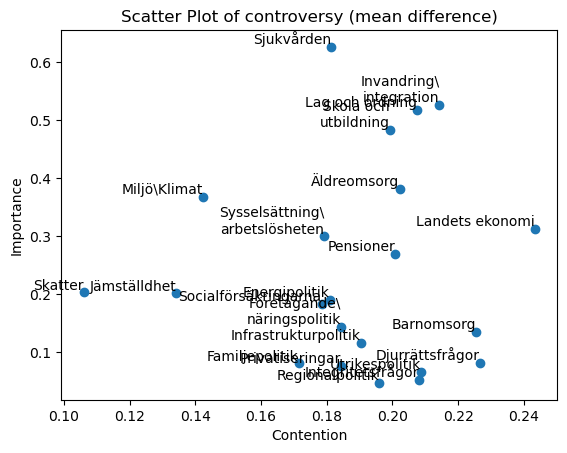

In [16]:
topics_diff_avg_list = list(topics_diff_avg.values())
topics_opinion_val_list = list(topics_opinion_val.values())
plt.scatter(topics_diff_avg_list, topics_opinion_val_list)
plt.xlabel('Contention')
plt.ylabel('Importance')
plt.title('Scatter Plot of controversy (mean difference)')
# plt.xlim(0, 2)
# plt.ylim(0, 2)
for i, label in enumerate(topics_opinion_val):
    plt.text(topics_diff_avg_list[i], topics_opinion_val_list[i], label, ha='right', va='bottom')
plt.savefig("controvery(mean difference).png")

[ 1.21717006 -0.27621894  0.59522786 -0.16185814 -0.32841461 -0.16772246
  0.3191897  -0.35666259  0.21555438  0.63591563  0.03468219  0.81464902
 -0.26146272  0.61607972  1.18181639  0.41861934 -1.8020233  -0.58393231
 -1.53126977  1.76204945 -2.71700457  0.37561568]


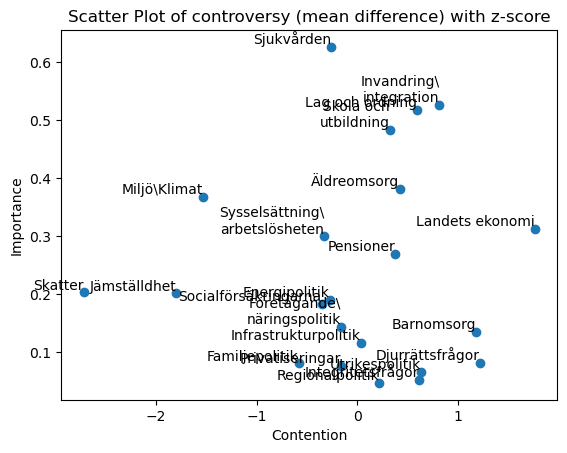

In [17]:
# z-score
import scipy.stats as stats
topics_diff_avg_list_z_score = stats.zscore(topics_diff_avg_list)
print(topics_diff_avg_list_z_score)
plt.scatter(topics_diff_avg_list_z_score, topics_opinion_val_list)
plt.xlabel('Contention')
plt.ylabel('Importance')
plt.title('Scatter Plot of controversy (mean difference) with z-score')
for i, label in enumerate(topics_opinion_val):
    plt.text(topics_diff_avg_list_z_score[i], topics_opinion_val_list[i], label, ha='right', va='bottom')
#plt.savefig("controvery(mean difference).png")

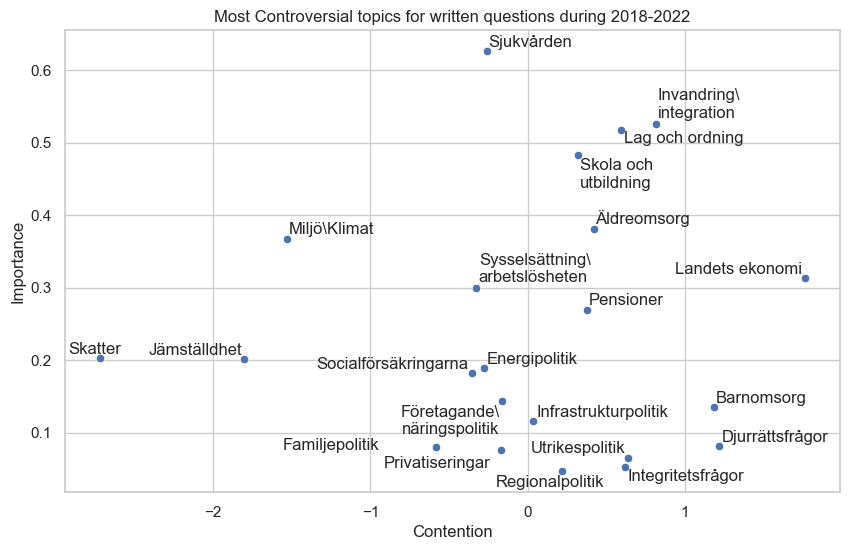

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from adjustText import adjust_text
# Calculate z-scores
topics_diff_avg_list_z_score = stats.zscore(topics_diff_avg_list)

# Create a DataFrame from your data
data = {'z_score': topics_diff_avg_list_z_score, 'opinion_val': topics_opinion_val_list}
df_plot = pd.DataFrame(data)

# Set up the Seaborn style
sns.set(style="whitegrid")

# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
scatter_plot = sns.scatterplot(x='z_score', y='opinion_val', data=df_plot)

# Add labels and title
plt.xlabel('Contention')
plt.ylabel('Importance')
plt.title('Most Controversial topics for written questions during 2018-2022')

# Add text annotations
# for i, label in enumerate(topics_opinion_val):
#     scatter_plot.text(df['z_score'][i], df['opinion_val'][i], label, ha='right', va='bottom')
texts = []
for i, label in enumerate(topics_opinion_val):
    texts.append(scatter_plot.text(df_plot['z_score'][i], df_plot['opinion_val'][i], label, ha='right', va='bottom'))
adjust_text(texts)
plt.savefig("controvery_written_q_2018-2022.png",dpi=300)


plt.show()

In [19]:
controversy_num = {}
for i, label in enumerate(topics_opinion_val):
    controversy_num[label] = df_plot['z_score'][i] * df_plot['opinion_val'][i]
    #print(f"{label}:{controversy_num}")
sorted_data = dict(sorted(controversy_num.items(), key=lambda item: item[1],reverse=True))

# Extract keys and values for plotting
keys = list(sorted_data.keys())
values = list(sorted_data.values())
for i in range(len(values)):
    print(f"{keys[i]}:{values[i]}")

Landets ekonomi:0.5517417352213393
Invandring\
integration:0.4287090482135203
Lag och ordning:0.30840243571672166
Äldreomsorg:0.15959862211889844
Barnomsorg:0.15954521198456922
Skola och
utbildning:0.15420852516717498
Pensioner:0.10141623228173592
Djurrättsfrågor:0.09965579842341354
Utrikespolitik:0.04173196348403907
Integritetsfrågor:0.03234418535083533
Regionalpolitik:0.010104111335465373
Infrastrukturpolitik:0.00401012783774339
Privatiseringar:-0.012788837663054262
Företagande\
näringspolitik:-0.023165945903540777
Familjepolitik:-0.04707954245672948
Energipolitik:-0.052308962100726344
Socialförsäkringarna:-0.06509092276868568
Sysselsättning\
arbetslösheten:-0.09831912285571381
Sjukvården:-0.1637410315248764
Jämställdhet:-0.3626571893520361
Skatter:-0.5518915535914941
Miljö\Klimat:-0.562741639396707


# Most controversial party


In [20]:
topic_sentiment = {}
num_appearance = {}
for i in range(len(df)):
    if (df.iloc[i]["question_date"][:4] > "2011") and (df.iloc[i]["question_date"][:4] < "2023"):
        topic = df.iloc[i]["id_topic_combined"]
        diff = df.iloc[i]["mean_diff"]
        party_ask = df.iloc[i]["undertecknare_partibet"]
        if topic in topic_sentiment:
            #print(topic_sentiment)
            if party_ask in topic_sentiment[topic]:
                topic_sentiment[topic][party_ask] += diff
                num_appearance[topic][party_ask] += 1
            else:
                topic_sentiment[topic][party_ask] = diff
                num_appearance[topic][party_ask] = 1

        else:
            #print(topic_sentiment)
            topic_sentiment[topic] = {}
            num_appearance[topic] = {}
            topic_sentiment[topic][party_ask] = diff
            num_appearance[topic][party_ask] = 1

for key in topic_sentiment:
    for party in topic_sentiment[key]:
        #print(key)
        differences = abs(topic_sentiment[key][party]/num_appearance[key][party])
        topic_sentiment[key][party] = differences

In [21]:
topic_sentiment_values = []
topics_diff = {}
topics_appearance = {}
topics_opinion_val = {}
for topic in topic_sentiment:
    #first_question = df.loc[df["id_topic_combined"] == topic].iloc[0]["question"]
    first_question = ''.join(df.loc[df["id_topic_combined"] == topic].iloc[:3]["question"].tolist())
    most_correlated_topic = find_most_correlated(first_question)
    
    value = combining_data_from_opinion("18-jun","22-jan",most_correlated_topic)
    #value = df_opinion[df_opinion["Topic"] == most_correlated_topic]["22-jan"].values[0]
    if most_correlated_topic in topics_diff:
        for key in topic_sentiment[topic]:
            if key in topics_diff[most_correlated_topic]:
                topics_diff[most_correlated_topic][key] += topic_sentiment[topic][key]
                topics_appearance[most_correlated_topic][key] += 1
            else:
                topics_diff[most_correlated_topic][key] = topic_sentiment[topic][key]
                topics_appearance[most_correlated_topic][key] = 1
            topics_opinion_val[most_correlated_topic][key] = value
    else:
        topics_diff[most_correlated_topic] = {}
        topics_appearance[most_correlated_topic] = {}
        topics_opinion_val[most_correlated_topic] = {}
        for key in topic_sentiment[topic]:
            topics_diff[most_correlated_topic][key] = topic_sentiment[topic][key]
            topics_appearance[most_correlated_topic][key] = 1
            topics_opinion_val[most_correlated_topic][key] = value
        
    #topic_sentiment_values.append(value)
   # print(topic)
   # print(value)

In [22]:
topics_diff_avg = {}
for key in topics_diff:
    topics_diff_avg[key] = {}
    for party in topics_diff[key]:
        differences = abs(topics_diff[key][party]/topics_appearance[key][party])
        topics_diff_avg[key][party] = differences

In [23]:
topics_diff_avg

{'Företagande\\\nnäringspolitik': {'S': 0.18286818560394194,
  'V': 0.18490273688567066,
  'MP': 0.08344111407253271,
  'FP': 0.07641242980801811,
  'M': 0.188397580973883,
  'C': 0.20011927172108432,
  'SD': 0.15703003380605168,
  'KD': 0.20057963210864005,
  'L': 0.0903477315150667},
 'Energipolitik': {'S': 0.13837111468131227,
  'C': 0.17808083954252124,
  'M': 0.1803379262019003,
  'SD': 0.20353654685708866,
  'V': 0.1209219321103285,
  'KD': 0.13571905278201615,
  'L': 0.12737461514718068,
  'MP': 0.09613901230690329},
 'Sjukvården': {'S': 0.18386512555880472,
  'V': 0.13937929533421992,
  'M': 0.19107658487168738,
  'SD': 0.21686136032887066,
  'L': 0.09448540428032477,
  'KD': 0.22377182287164032,
  'C': 0.1747471292813619},
 'Infrastrukturpolitik': {'S': 0.1783287279271613,
  'MP': 0.11541370331513064,
  'V': 0.1807226762710345,
  'M': 0.16883395986483857,
  'C': 0.14157126399897138,
  'FP': 0.15655699440477683,
  'SD': 0.20685955726715047,
  'KD': 0.18821003874080955,
  'L': 0

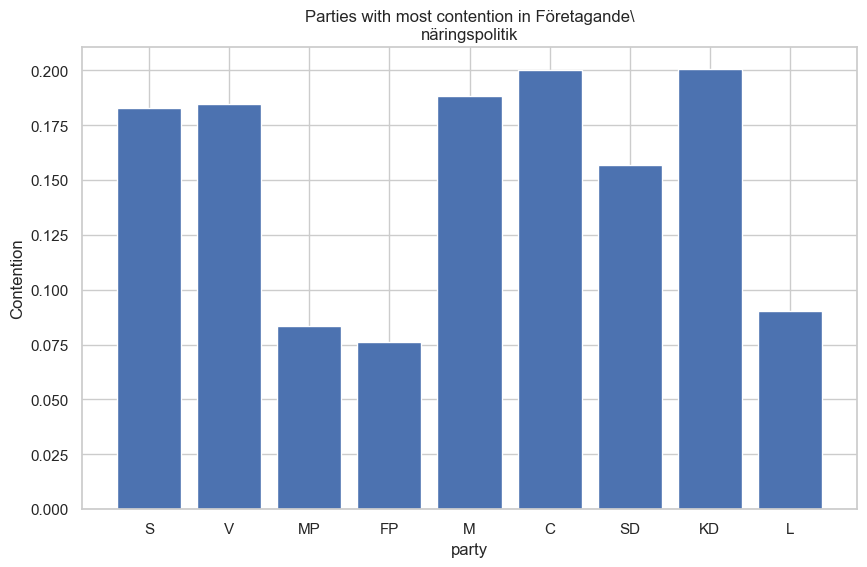

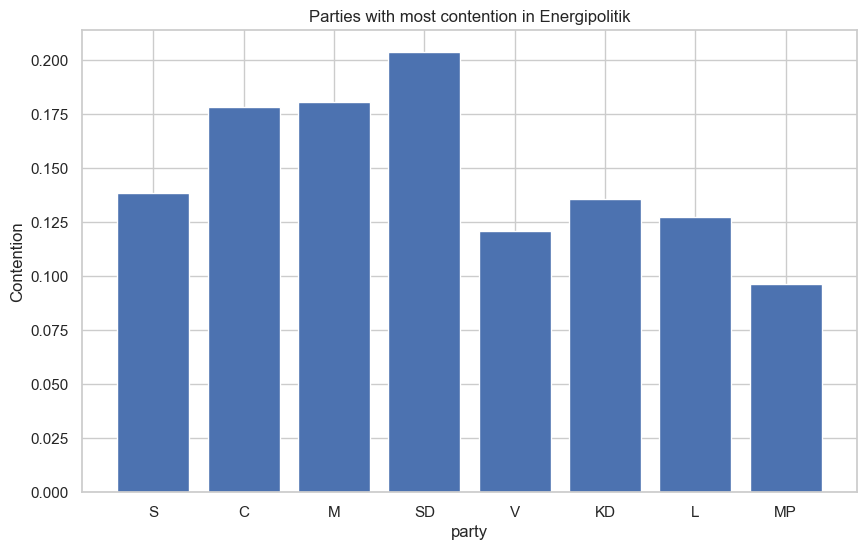

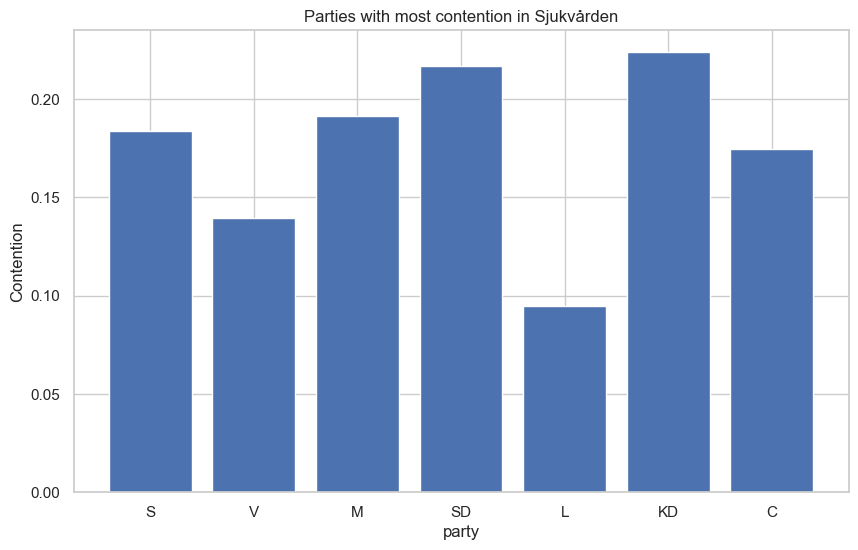

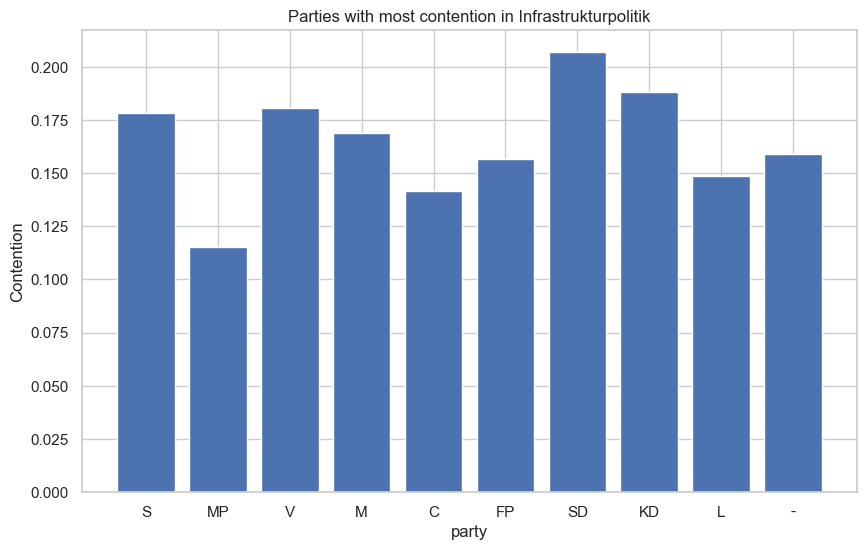

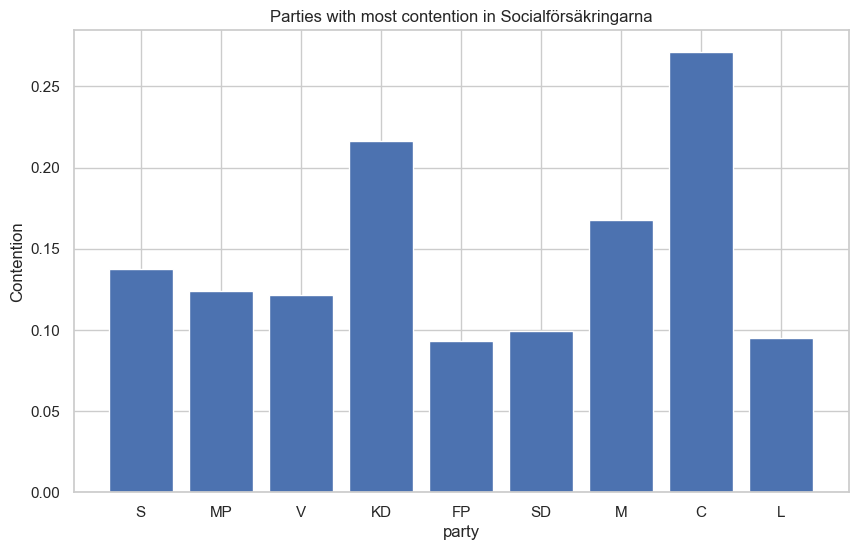

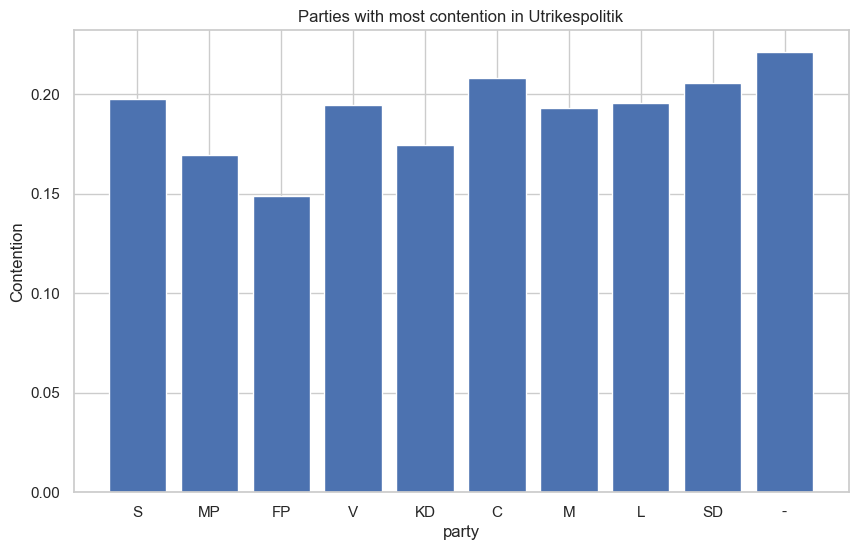

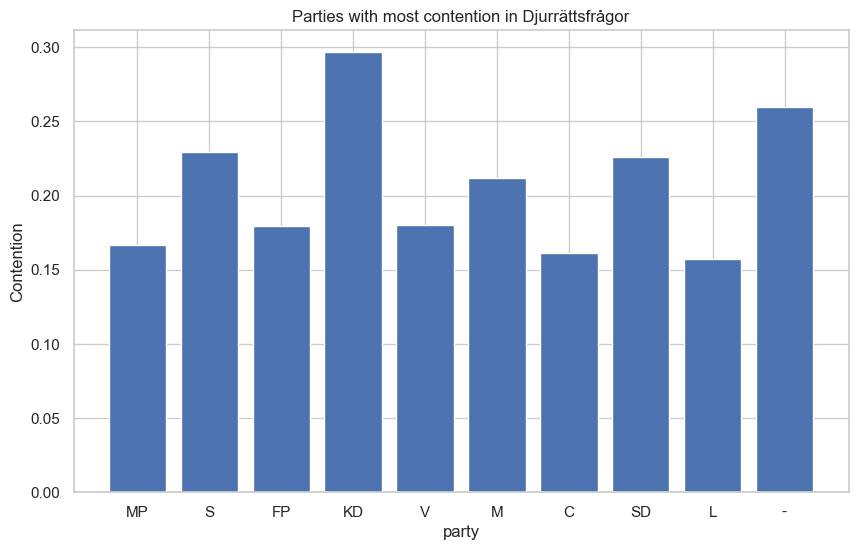

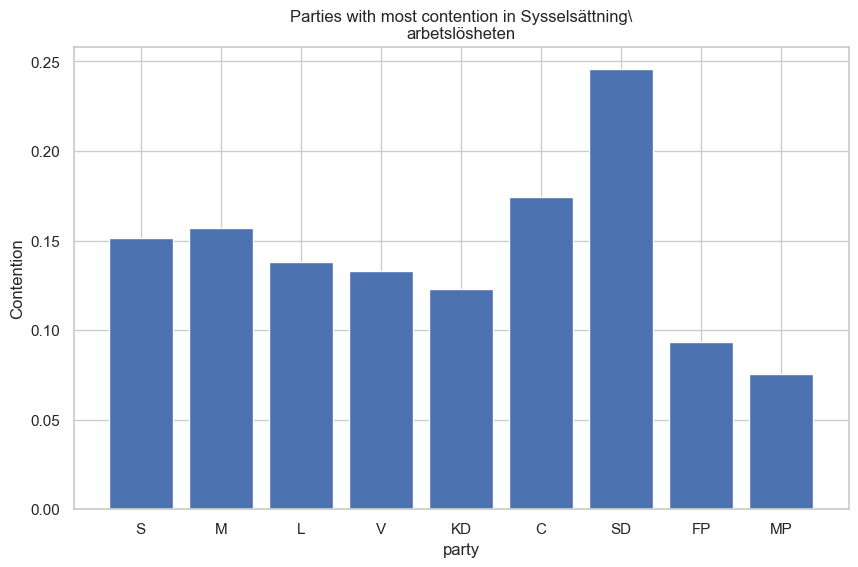

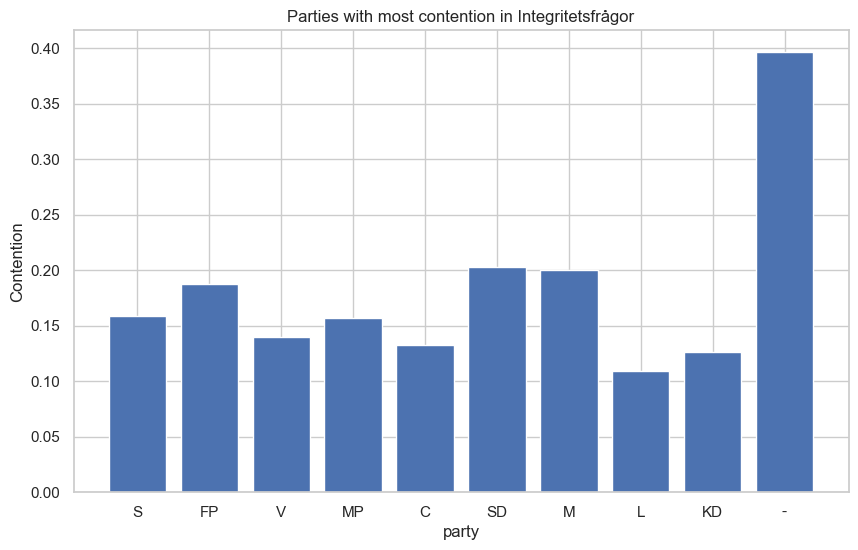

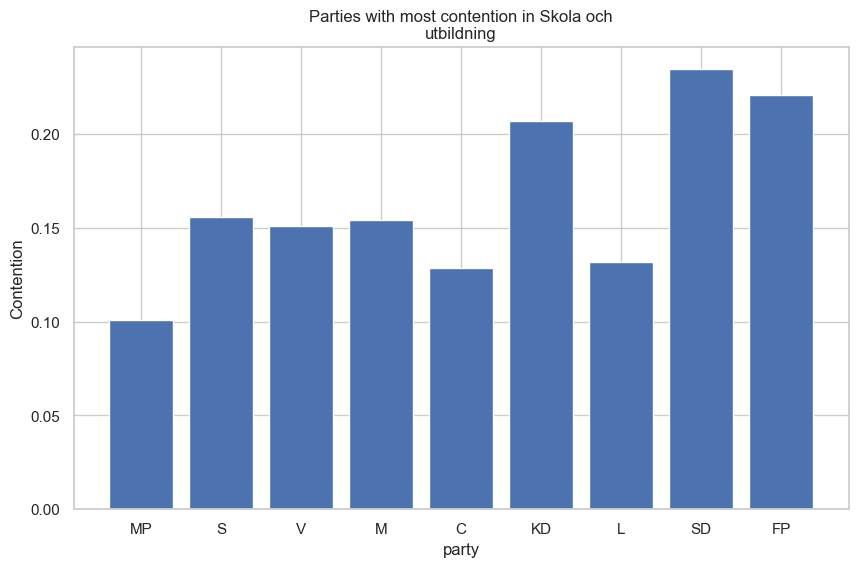

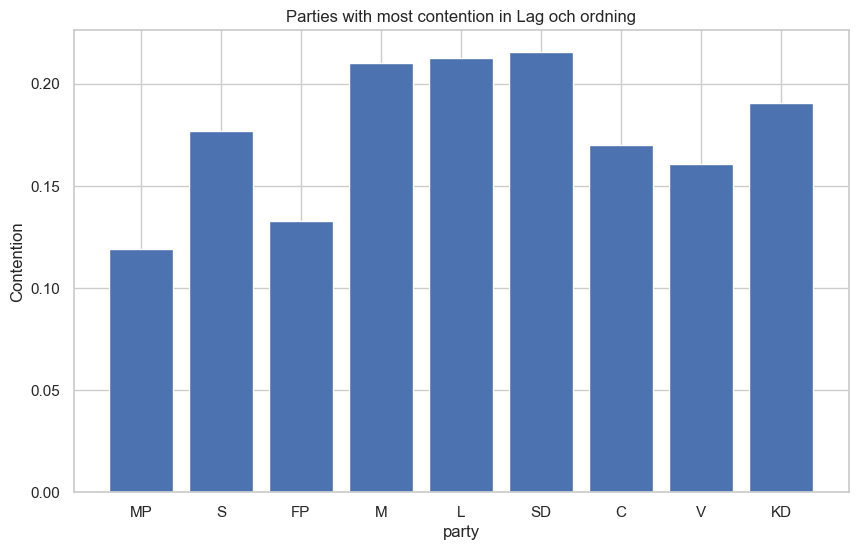

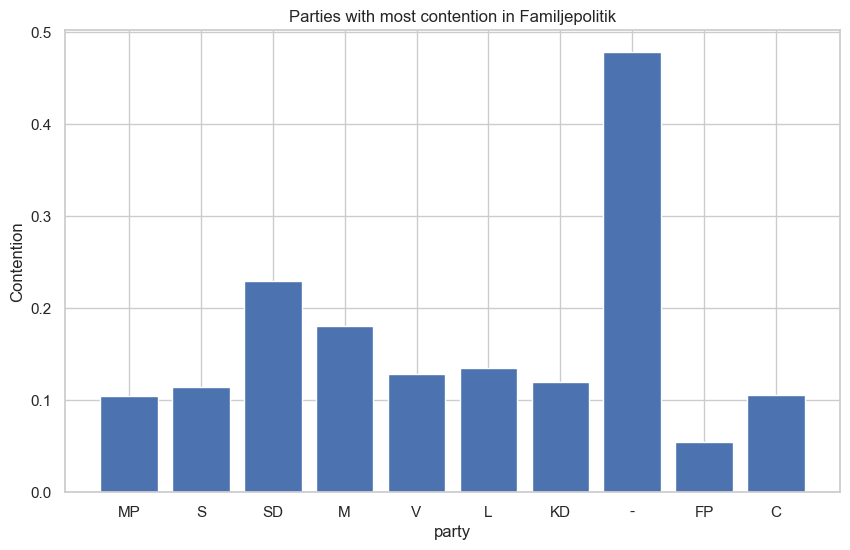

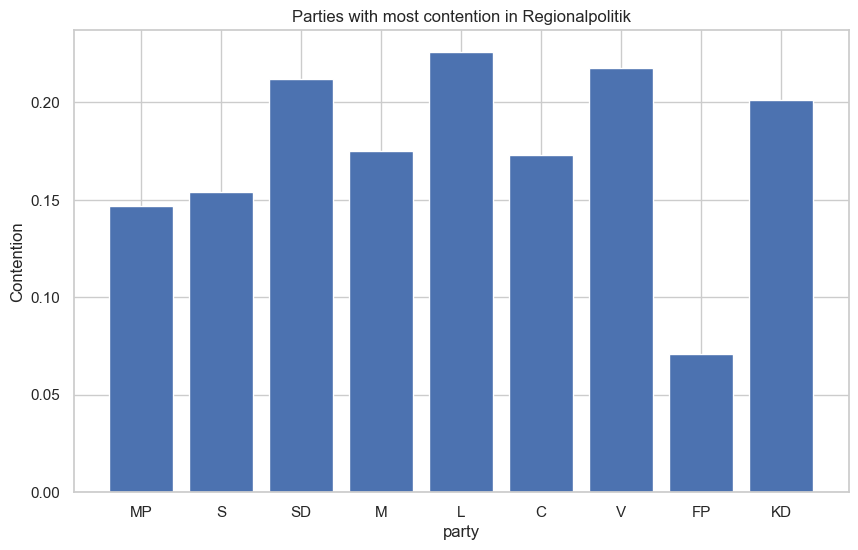

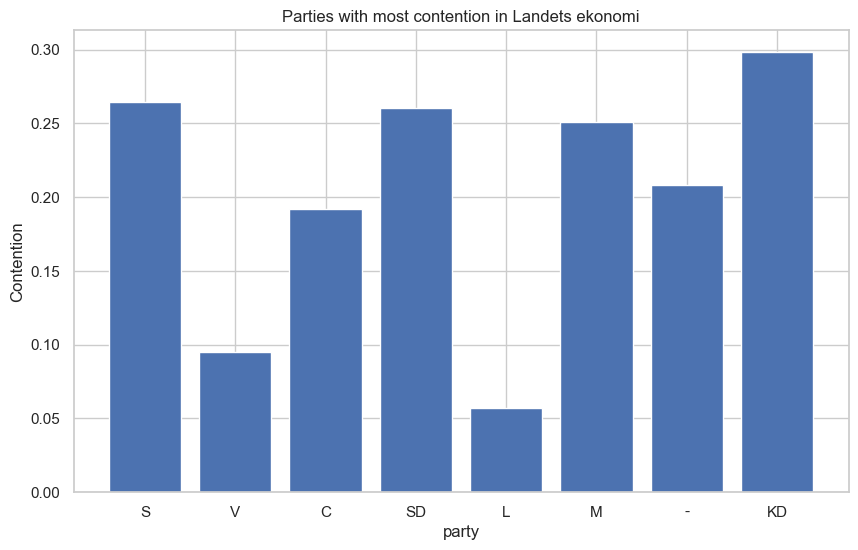

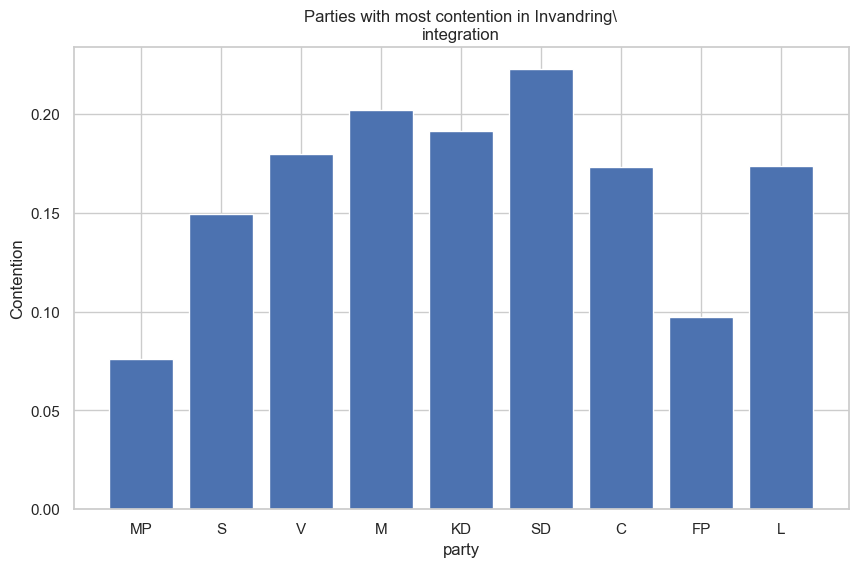

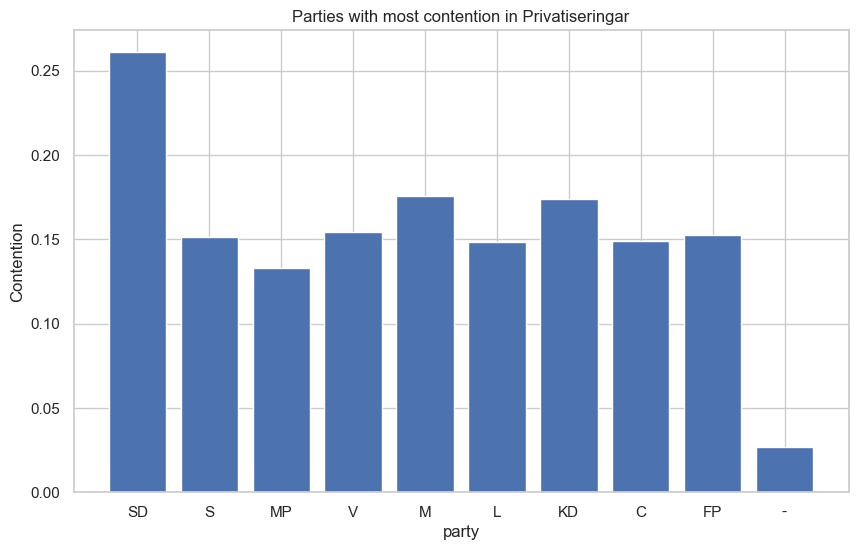

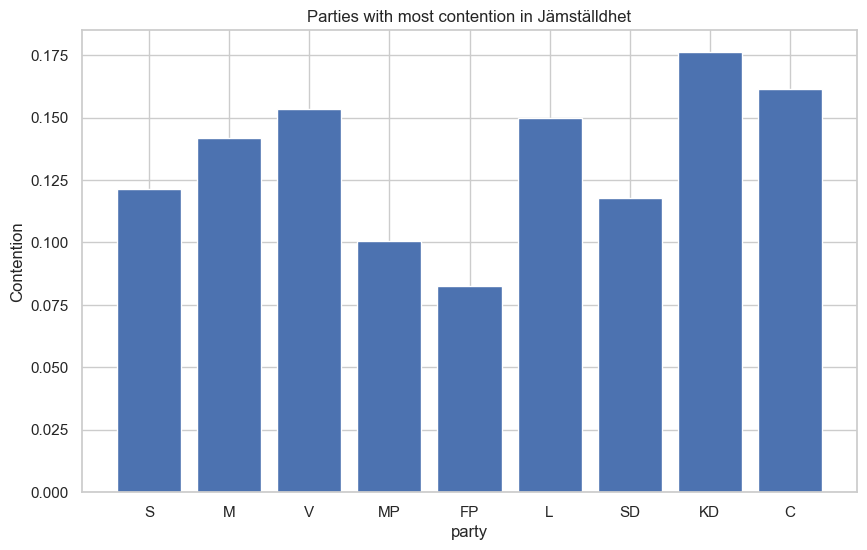

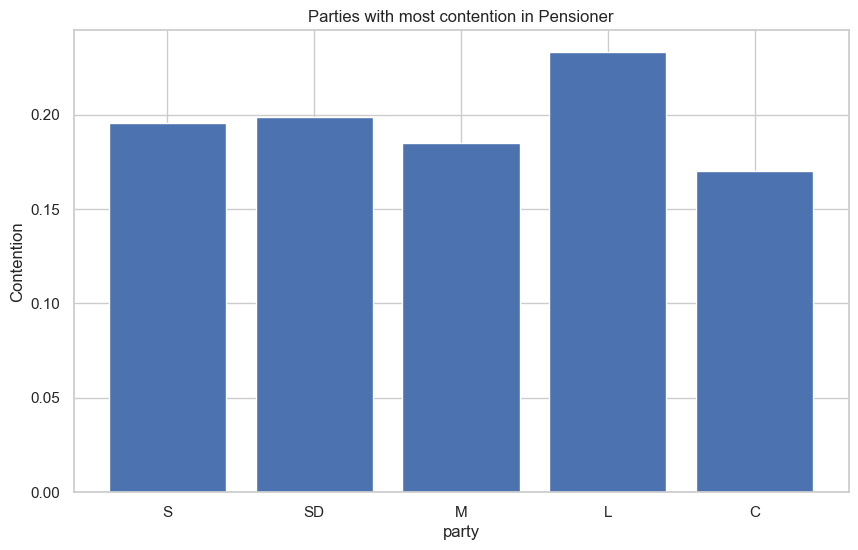

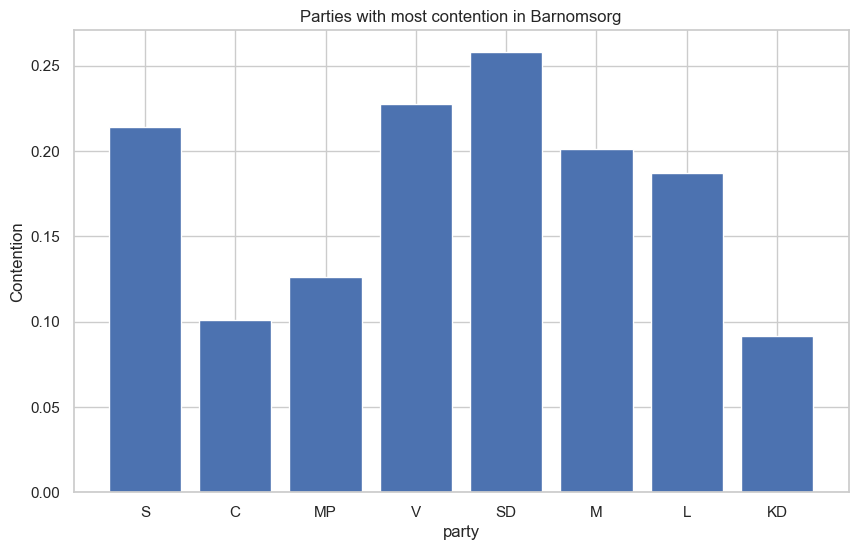

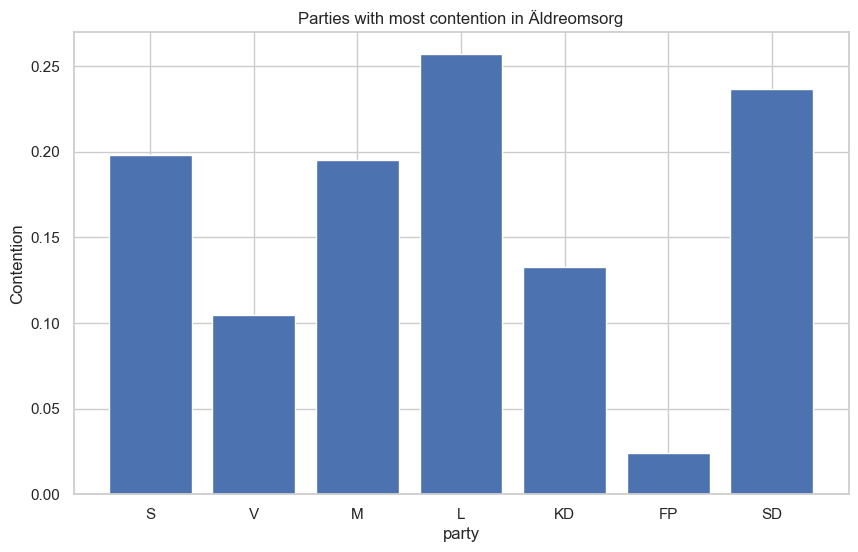

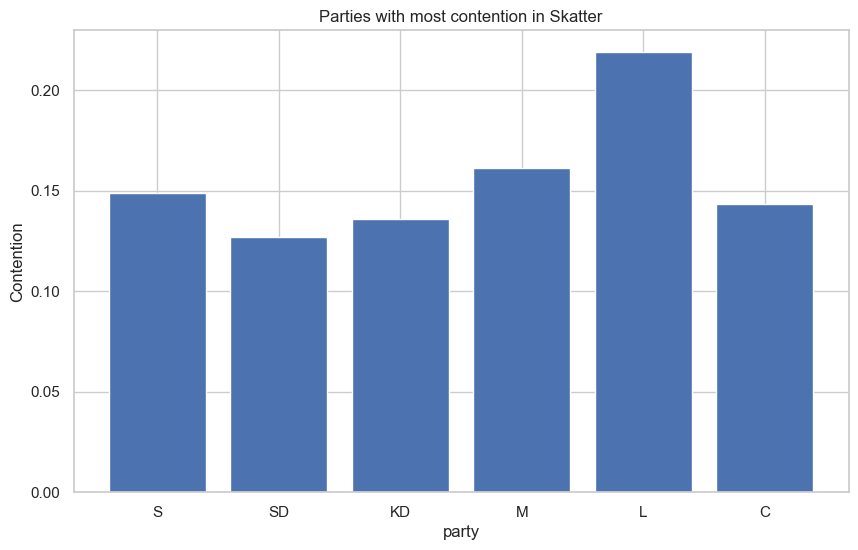

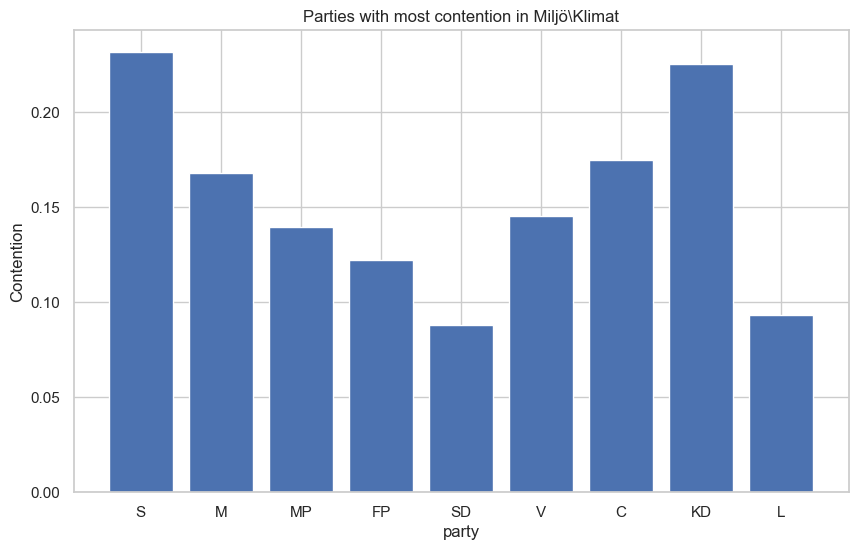

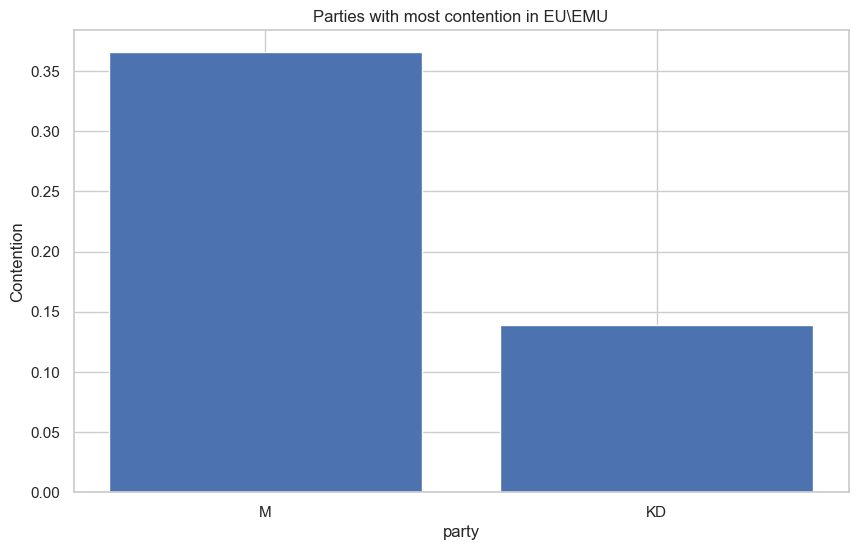

In [24]:
for key in topics_diff_avg:
    
    topics_diff_avg_list = list(topics_diff_avg[key].values())
    topics_diff_avg_list_keys = list(topics_diff_avg[key].keys())
    topics_opinion_val_list = list(topics_opinion_val[key].values())
    #plt.plot(topics_diff_avg_list_keys,topics_diff_avg_list)
    plt.figure(figsize=(10, 6))  # You may adjust the figure size
    plt.bar(topics_diff_avg_list_keys, topics_diff_avg_list, label=key)
    plt.xlabel('party')
    plt.ylabel('Contention')
    plt.title(f'Parties with most contention in {key}')
    #plt.legend()
    plt.show()  # Show the plot for each key
    #plt.scatter(topics_diff_avg_list, topics_opinion_val_list,label=key)
# plt.xlim(0, 2)
# plt.ylim(0, 2)
#for i, label in enumerate(topics_opinion_val):
    #plt.text(topics_diff_avg_list[i], topics_opinion_val_list[i], label, ha='right', va='bottom')
#plt.savefig("controvery(mean difference).png")

In [25]:
topics_opinion_val

{'Företagande\\\nnäringspolitik': {'S': 0.143125,
  'V': 0.143125,
  'MP': 0.143125,
  'FP': 0.143125,
  'M': 0.143125,
  'C': 0.143125,
  'SD': 0.143125,
  'KD': 0.143125,
  'L': 0.143125},
 'Energipolitik': {'S': 0.18937500000000002,
  'C': 0.18937500000000002,
  'M': 0.18937500000000002,
  'SD': 0.18937500000000002,
  'V': 0.18937500000000002,
  'KD': 0.18937500000000002,
  'L': 0.18937500000000002,
  'MP': 0.18937500000000002},
 'Sjukvården': {'S': 0.62625,
  'V': 0.62625,
  'M': 0.62625,
  'SD': 0.62625,
  'L': 0.62625,
  'KD': 0.62625,
  'C': 0.62625},
 'Infrastrukturpolitik': {'S': 0.115625,
  'MP': 0.115625,
  'V': 0.115625,
  'M': 0.115625,
  'C': 0.115625,
  'FP': 0.115625,
  'SD': 0.115625,
  'KD': 0.115625,
  'L': 0.115625,
  '-': 0.115625},
 'Socialförsäkringarna': {'S': 0.1825,
  'MP': 0.1825,
  'V': 0.1825,
  'KD': 0.1825,
  'FP': 0.1825,
  'SD': 0.1825,
  'M': 0.1825,
  'C': 0.1825,
  'L': 0.1825},
 'Utrikespolitik': {'S': 0.065625,
  'MP': 0.065625,
  'FP': 0.065625,
 

In [26]:
topics_diff_avg

{'Företagande\\\nnäringspolitik': {'S': 0.18286818560394194,
  'V': 0.18490273688567066,
  'MP': 0.08344111407253271,
  'FP': 0.07641242980801811,
  'M': 0.188397580973883,
  'C': 0.20011927172108432,
  'SD': 0.15703003380605168,
  'KD': 0.20057963210864005,
  'L': 0.0903477315150667},
 'Energipolitik': {'S': 0.13837111468131227,
  'C': 0.17808083954252124,
  'M': 0.1803379262019003,
  'SD': 0.20353654685708866,
  'V': 0.1209219321103285,
  'KD': 0.13571905278201615,
  'L': 0.12737461514718068,
  'MP': 0.09613901230690329},
 'Sjukvården': {'S': 0.18386512555880472,
  'V': 0.13937929533421992,
  'M': 0.19107658487168738,
  'SD': 0.21686136032887066,
  'L': 0.09448540428032477,
  'KD': 0.22377182287164032,
  'C': 0.1747471292813619},
 'Infrastrukturpolitik': {'S': 0.1783287279271613,
  'MP': 0.11541370331513064,
  'V': 0.1807226762710345,
  'M': 0.16883395986483857,
  'C': 0.14157126399897138,
  'FP': 0.15655699440477683,
  'SD': 0.20685955726715047,
  'KD': 0.18821003874080955,
  'L': 0

# Look at data between 2012 and 2022

In [27]:
#file_path_sentiments = "../data/data_all/data_question_all_sentiment.csv"

df = pd.read_csv(file_path_sentiments)
df = df.dropna(subset=["question"])
df = df.reset_index()
#file_path_topics = '../data/data_topic_all_notreduedtopics.json'
with open(file_path_topics, 'r') as openfile:
    # Reading from json file
    json_object = json.load(openfile)
df2 = pd.DataFrame(json_object)

df["id_topic_combined"] = df2["id_topic_combined"]
df["mean_diff"] = None

for i in range(len(df)):
    df.at[i,"question_BERT_probs"] = ast.literal_eval(df.iloc[i]["question_BERT_probs"])
    df.at[i,"answer_BERT_probs"] = ast.literal_eval(df.iloc[i]["answer_BERT_probs"])
    differences = [abs(df.iloc[i]["question_BERT_probs"][l] - df.iloc[i]["answer_BERT_probs"][l]) for l in [0,2]]
    sum_diff = sum(differences)
    df.at[i,"mean_diff"] = sum_diff
df = df.dropna(subset=["answer","besvaradav_partibet"])
df = df.reset_index()

In [28]:
topic_sentiment = {}
num_appearance = {}
for i in range(len(df)):
    regering_list = [50]
    if (df.iloc[i]["question_date"][:4] > "2011") and (df.iloc[i]["question_date"][:4] < "2023"):
    #if df.iloc[i]["regering"] in regering_list:
        topic = df.iloc[i]["id_topic_combined"]
        diff = df.iloc[i]["mean_diff"]
        if topic in topic_sentiment:
            #differences = [abs(topic_sentiment[topic][l] + diff[l]) for l in [0,1,2]]
            topic_sentiment[topic] += diff
            num_appearance[topic] += 1
        else:
            topic_sentiment[topic] = diff
            num_appearance[topic] = 1
for key in topic_sentiment:
    differences = abs(topic_sentiment[key]/num_appearance[key])
    topic_sentiment[key] = differences

In [29]:
topic_sentiment_values = []
topics_diff = {}
topics_appearance = {}
topics_opinion_val = {}
for topic in topic_sentiment:
    #first_question = df.loc[df["id_topic_combined"] == topic].iloc[0]["question"]
    first_question = ''.join(df.loc[df["id_topic_combined"] == topic].iloc[:3]["question"].tolist())
    most_correlated_topic = find_most_correlated(first_question)
    
    value = combining_data_from_opinion("12-jun","22-jan",most_correlated_topic)
    #value = df_opinion[df_opinion["Topic"] == most_correlated_topic]["22-jan"].values[0]
    if most_correlated_topic in topics_diff:
        #differences = [abs(topic_sentiment[topic][l] + diff[l]) for l in [0,1,2]]
        topics_diff[most_correlated_topic] += topic_sentiment[topic]
        topics_appearance[most_correlated_topic] += 1
        #topics_opinion_val[most_correlated_topic] += value
    else:
        topics_diff[most_correlated_topic] = topic_sentiment[topic]
        topics_appearance[most_correlated_topic] = 1
        topics_opinion_val[most_correlated_topic] = value
        
    #topic_sentiment_values.append(value)
   # print(topic)
   # print(value)

In [30]:
topics_diff_avg = {}
for key in topics_diff:
    differences = abs(topics_diff[key]/topics_appearance[key])
    topics_diff_avg[key] = differences

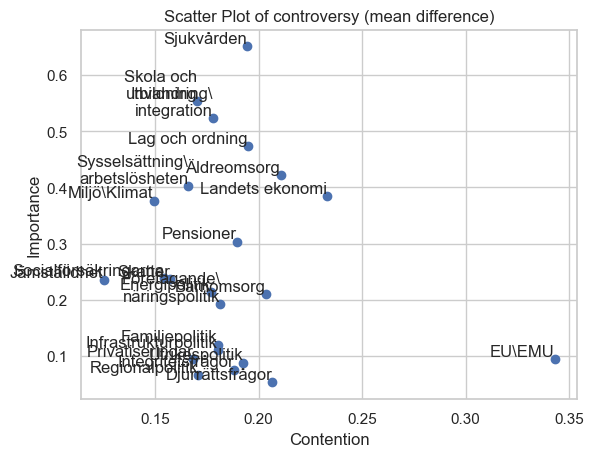

In [31]:
topics_diff_avg_list = list(topics_diff_avg.values())
topics_opinion_val_list = list(topics_opinion_val.values())
plt.scatter(topics_diff_avg_list, topics_opinion_val_list)
plt.xlabel('Contention')
plt.ylabel('Importance')
plt.title('Scatter Plot of controversy (mean difference)')
# plt.xlim(0, 2)
# plt.ylim(0, 2)
for i, label in enumerate(topics_opinion_val):
    plt.text(topics_diff_avg_list[i], topics_opinion_val_list[i], label, ha='right', va='bottom')
plt.savefig("controvery(mean difference).png")

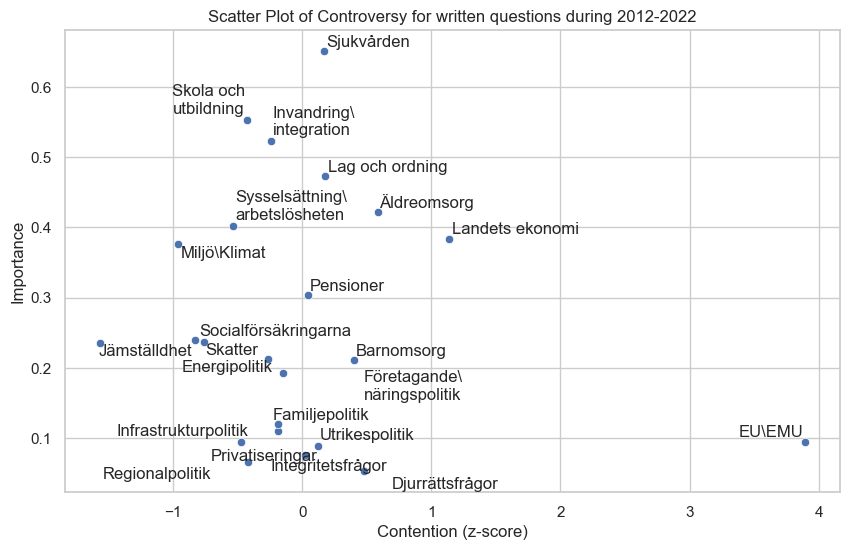

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from adjustText import adjust_text
# Calculate z-scores
topics_diff_avg_list_z_score = stats.zscore(topics_diff_avg_list)

# Create a DataFrame from your data
data = {'z_score': topics_diff_avg_list_z_score, 'opinion_val': topics_opinion_val_list}
df = pd.DataFrame(data)

# Set up the Seaborn style
sns.set(style="whitegrid")

# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
scatter_plot = sns.scatterplot(x='z_score', y='opinion_val', data=df)

# Add labels and title
plt.xlabel('Contention (z-score)')
plt.ylabel('Importance')
plt.title('Scatter Plot of Controversy for written questions during 2012-2022')

# Add text annotations
# for i, label in enumerate(topics_opinion_val):
#     scatter_plot.text(df['z_score'][i], df['opinion_val'][i], label, ha='right', va='bottom')
texts = []
for i, label in enumerate(topics_opinion_val):
    texts.append(scatter_plot.text(df['z_score'][i], df['opinion_val'][i], label, ha='right', va='bottom'))
adjust_text(texts)
plt.savefig("controvery_written_q_2012-2022.png",dpi=300)


plt.show()